# **Model**

Epoch 1/300


C:\Users\1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.2762 - mae: 0.4323 - val_loss: 0.3705 - val_mae: 0.5353
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2282 - mae: 0.3875 - val_loss: 0.3386 - val_mae: 0.5171
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2447 - mae: 0.3914 - val_loss: 0.3083 - val_mae: 0.4983
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2229 - mae: 0.3771 - val_loss: 0.2813 - val_mae: 0.4810
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1642 - mae: 0.3240 - val_loss: 0.2578 - val_mae: 0.4649
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1786 - mae: 0.3421 - val_loss: 0.2387 - val_mae: 0.4509
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1556 - mae: 0.3134 - val_loss: 0.2220 - val_mae: 0.4397
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1529 - mae: 0.3099 - val_loss: 0.2069 - val_mae: 0.4267
Epoch 9/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1214 - mae: 0.2869 - va

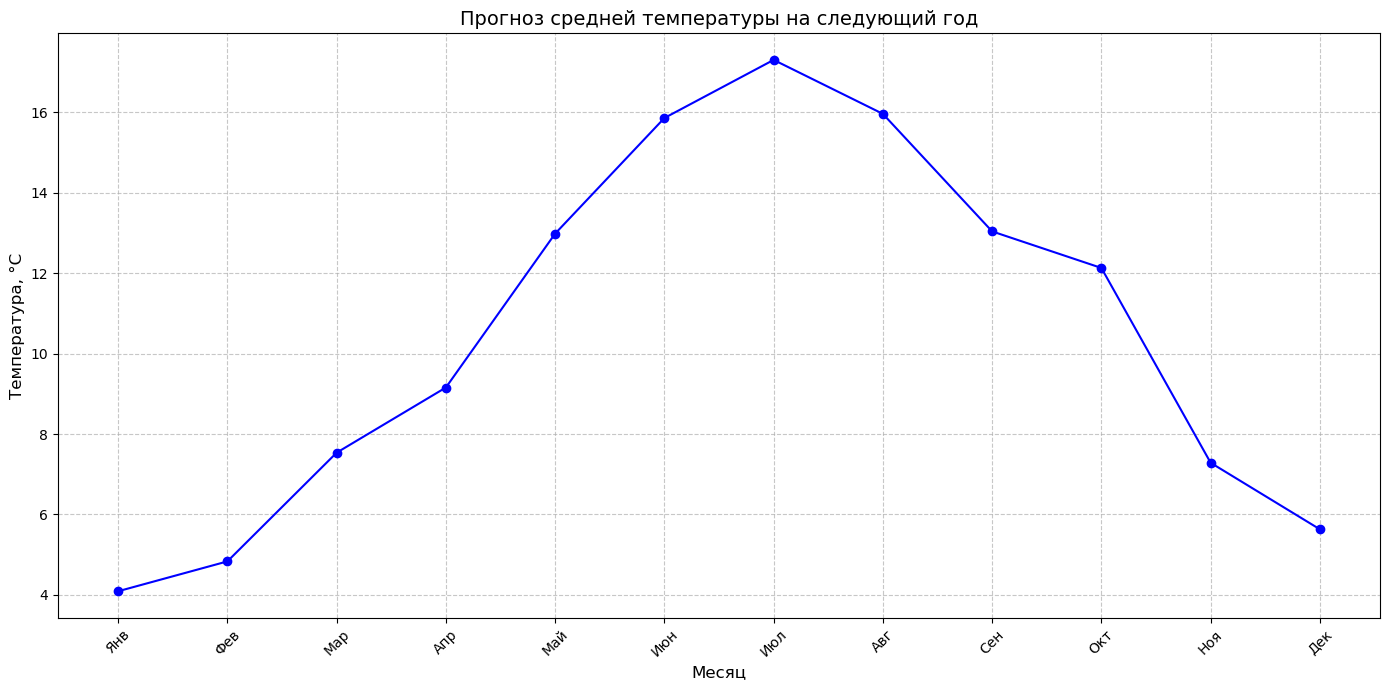

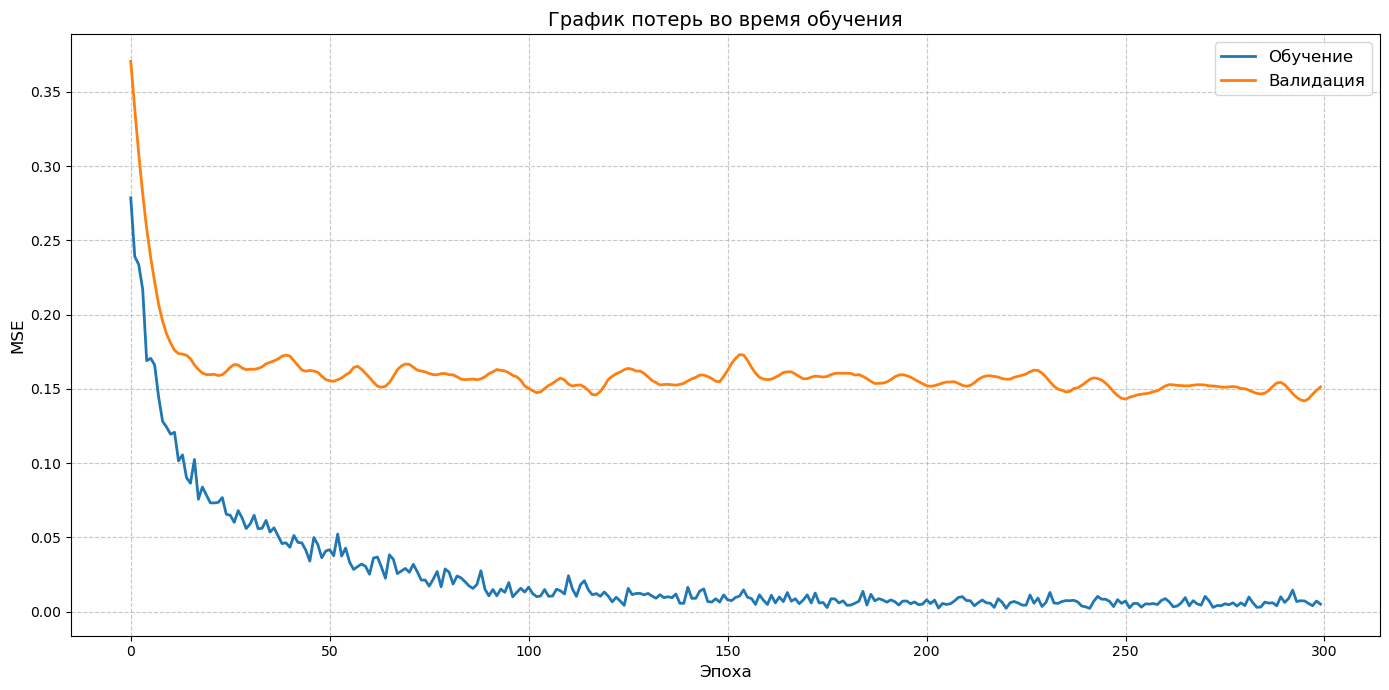

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

class WeatherPredictor:
    def __init__(self):
        self.model = None
        self.scaler = MinMaxScaler()
        self.history = None

    def build_model(self, input_shape):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(12)
        ])
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

    def train(self, X_train, y_train, epochs=300, batch_size=4):
        self.history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            verbose=1
        )

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

    def predict_next_year(self, last_year_data):
        return self.model.predict(np.array([last_year_data]))[0]

def load_data(file_path):
    with open(file_path, 'r') as f:
        data = f.read().strip().split(',')
    data = [float(x) for x in data]
    return data

def prepare_dataset(data):
    data = np.array(data)
    num_years = len(data) // 12
    data = data[:num_years*12].reshape(-1, 12)
    X = data[:-1]
    y = data[1:]
    return X, y

def plot_predictions(predictions):
    months = ['Янв','Фев','Мар','Апр','Май','Июн','Июл','Авг','Сен','Окт','Ноя','Дек']
    plt.figure(figsize=(14, 7))
    plt.plot(months, predictions, marker='o', linestyle='-', color='b')
    plt.title('Прогноз средней температуры на следующий год', fontsize=14)
    plt.xlabel('Месяц', fontsize=12)
    plt.ylabel('Температура, °C', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('forecast.png')
    plt.show()

def plot_training_history(history):
    plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Обучение', linewidth=2)
    plt.plot(history.history['val_loss'], label='Валидация', linewidth=2)
    plt.title('График потерь во время обучения', fontsize=14)
    plt.xlabel('Эпоха', fontsize=12)
    plt.ylabel('MSE', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def main():
    raw_data = load_data('./data/avgTempData.txt')
    X, y = prepare_dataset(raw_data)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, shuffle=False
    )
    predictor = WeatherPredictor()
    predictor.model = predictor.build_model(X_train.shape[1])
    predictor.train(X_train, y_train)
    loss, mae = predictor.evaluate(X_test, y_test)
    print(f"Test MAE: {mae:.2f}°C")
    last_year = X_scaled[-1].reshape(1, -1)
    predictions = predictor.model.predict(last_year)
    predicted_temp = scaler.inverse_transform(predictions).flatten()
    plot_predictions(predicted_temp)
    plot_training_history(predictor.history)
    np.savetxt('predictions.txt', predicted_temp, fmt='%.1f')
    predictor.model.save('pretrained_model.h5')

if __name__ == "__main__":
    main()